##### Copyright 2024 Google LLC.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Illustrating a book using Imagen 3

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/examples/story_illustration.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

In this guide, you are going to use multiple Gemini features (long context, multimodality, structured output, file API, chat mode...) in conjunction with the Imagen 3 model to illustrate a book.

Each concept will be explained along the way, but if you need a simpler introduction to Imagen 3, check the [getting started](../quickstarts/Get_started_imagen.ipynb) notebook, or the [Imagen documentation](https://ai.google.dev/gemini-api/docs/imagen).

Note: for the sake of the notebook's size (and your billing if you run it), the number of images has been limited to 3 characters and 3 chapters each time, but feel free to remove the limitation if you want more with your own experimentations.

<font color='red'>Image generation is a paid-only feature and won't work if you are on the free tier. Check the [pricing](https://ai.google.dev/pricing#imagen3) page for more details.</font>

## 0/ Setup

This section install the SDK, set it up using your [API key](../quickstarts/Authentication.ipynb), imports the relevant libs, downloads the sample videos and upload them to Gemini.

Just collapse (click on the little arrow on the left of the title) and run this section if you want to jump straight to the examples (just don't forget to run it otherwise nothing will work).

### Install SDK


In [ ]:
!pip install -U -q "google-genai"

### Setup your API key

To run the following cell, your API key must be stored it in a Colab Secret named `GOOGLE_API_KEY`. If you don't already have an API key, or you're not sure how to create a Colab Secret, see [Authentication](../quickstarts/Authentication.ipynb) for an example.

In [ ]:
from google.colab import userdata

GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')

### Initialize SDK client

With the new SDK you now only need to initialize a client with you API key (or OAuth if using [Vertex AI](https://link_to_vertex_AI)). The model is now set in each call.

In [ ]:
from google import genai
from google.genai import types

client = genai.Client(api_key=GOOGLE_API_KEY)

### Imports

Some imports to display markdown text and images in Colab.

In [ ]:
import json
from PIL import Image
from IPython.display import display, Markdown

### Select models

In [ ]:
imagen_model_name = "imagen-3.0-generate-002"  # @param ["imagen-3.0-generate-002"] {"allow-input":true, isTemplate: true}
gemini_model_name = "gemini-2.0-flash-exp"  # @param ["gemini-1.5-flash-8b","gemini-1.5-flash-002","gemini-2.0-flash-lite-02-05","gemini-2.0-flash", "gemini-2.0-pro-exp-02-05"] {"allow-input":true, isTemplate: true}

For the sake of the notebook's size (and your billing if you run it), the number of images has been limited to 3 characters and 3 chapters each time, but feel free to remove the limitation if you want more with your own experimentations.

In [ ]:
max_character_images = 3 # @param {type:"integer",isTemplate: true, min:1}
max_chapter_images = 3 # @param {type:"integer",isTemplate: true, min:1}

# Illustrate a book: The Wind in the Willows

## 1/ Get a book and upload using the File API

Start by downloading a book from the open-source [Project Gutenberg](www.gutenberg.org) library. For example, it can be [The Wind in the Willows](https://en.wikipedia.org/wiki/The_Wind_in_the_Willows) from Kenneth Grahame.

`client.files.upload` is used to upload the file so that Gemini can easily access it.

In [ ]:
import requests

url = "https://www.gutenberg.org/cache/epub/289/pg289.txt"  # @param {type:"string"}

response = requests.get(url)
with open("book.txt", "wb") as file:
    file.write(response.content)

book = client.files.upload(file="book.txt")


## 2/ Start the chat

You are going to use [chat mode](https://ai.google.dev/gemini-api/docs/text-generation?lang=python#chat) here so that Gemini will keep the history of what you asked it, and also so that you don't have to send it the book every time. More details on chat mode in the [get started](https://colab.sandbox.google.com/github/google-gemini/cookbook/blob/main/gemini-2/Get_started.ipynb#scrollTo=b6sB7W-jdGxJ) notebook.

You should also define the format of the output you want using [structured output](https://ai.google.dev/gemini-api/docs/structured-output?lang=python#generate-json). We will mainly use Gemini to generate prompts so let's define a Pydantic model with two fields, a name and a prompt:

In [ ]:
from pydantic import BaseModel

class Prompts(BaseModel):
    name: str
    prompt: str


`client.chats.create` starts the chat and defines its main parameters (model and the output we want).

In [ ]:
# Re-run this cell if you want to start anew.
chat = client.chats.create(
    model=gemini_model_name,
    config=types.GenerateContentConfig(
        response_mime_type="application/json",
        response_schema=list[Prompts],
    ),
)

chat.send_message(
    [
        "Here's a book, we are going to illustrate it. Don't say anything for now, instructions will follow.",
        book
    ]
);

The first message sent to the model is just to give it a bit of context ("*we are going to illustrate it*"), and more importantly give it the book.

It could have been done during the next step, especially since we're not interested in what the model has to say this time, but splitting the two steps makes it clearer.

## 3/ Define a style

If you want to test a specific style, just write it down and Gemini will use it. Still, tell Gemini about it so it will adapt the prompts it will generate accordingly.

If you prefer to let Gemini choose the best style for the book, leave the style empty and ask Gemini to define a style fitting to the book.

In [ ]:
style = "" # @param {type:"string", "placeholder":"Write your own style or leave empty to let Gemini generate one"}

if style=="":
  response = chat.send_message("""
    Can you define a art style that would fit the story?
    Just give us the promt for the art syle that we will add to the furture prompts.
    """)
  style = json.loads(response.text)[0]["prompt"]
else:
  chat.send_message(f"""
    The art style will be:"{style}".
    Keep that in mind when generating future prompts.
    Keep quiet for now, instructions will follow.
  """);

display(Markdown(f"### Style:"))
print(style)

style = f'Follow this style: "{style}" '

### Style:

detailed anthropomorphic animals, whimsical, storybook illustration, watercolor and ink, Arthur Rackham


We will also define some more instructions which will act as "system instructions" or a negative prompt to tell the model what we do not want to see (text on the images).

In [ ]:
system_instructions = """
  There must be no text on the image, it should not look like a cover page.
  It should be an full illustration with no borders, titles, nor description.
  Stay family-friendly with uplifting colors.
"""

## 4/ Generate portraits of the main characters

You are now ready to start generating images, starting with the main characters.

Ask Gemini to describe each of the main characters (excluding children as Imagen can't generate images of them) and check that the output follows the format requested.


In [ ]:
response = chat.send_message("""
  Can you describe the main characters (only the adults) and
  prepare a prompt describing them with as much details as possible (use the descriptions from the book)
  so we can generate images of them? Each prompt should be at least 50 words.
""")

characters = json.loads(response.text)[:max_character_images]

print(json.dumps(characters, indent=4))

[
    {
        "name": "ratty",
        "prompt": "Create a detailed illustration of Ratty, the Water Rat, in the style of Arthur Rackham. He is a self-sufficing sort of animal, rooted to the land and a freshwater mariner. He has a neat little brown paw. His face is gentle but knowing, his fur well-kept, and his whiskers twitch with curiosity and enthusiasm. Clothe him in well-worn but presentable riverbank attire: perhaps a tweed jacket, a patterned waistcoat, and sturdy trousers. Ensure his expression conveys a sense of loyalty, practicality, and an inherent love for his riverbank home. The style should be reminiscent of classic storybook illustrations."
    },
    {
        "name": "badger",
        "prompt": "Illustrate Mr. Badger, depicting his solid and respectable nature. His shoes should be covered with mud, and he is looking rough and touzled; but then he has never been a very smart man at the best of times. Depict him as a sturdy, powerful figure, with a gruff but kindly fac

Now that you have the prompts, you just need to loop on all the characters and have Imagen generate an image for them. This is done using `client.models.generate_images`.

For an extensive explanation on the Imagen model and the `generate_images` options, check the [getting started with Imagen](../quickstarts/get_started_imagen.ipynb) notebook. But here's a quick overview of what being used here:
* `prompt` is the prompt passed down to Imagen. We're not just sending what Gemini has generate to describe the chacaters but also our style and our system instructions.
* you only need one image, so `number_of_images` is set to 1
* `safety_filter_level` is set to the higher level because the images needs to be family friendly
* `person_generation` is disable since none of the characters are people

In [ ]:
for character in characters:
  display(Markdown(f"### {character['name']}"))
  display(Markdown(character['prompt']))

  image_generated = client.models.generate_images(
      model=imagen_model_name,
      prompt=character['prompt'] + style + system_instructions,
      config=types.GenerateImagesConfig(
          number_of_images=1,
          safety_filter_level="BLOCK_LOW_AND_ABOVE",
          person_generation="ALLOW_ADULT",
          aspect_ratio="9:16"
      )
  )

  if image_generated.generated_images is not None:
    for generated_image in image_generated.generated_images:
      generated_image.image.show()

Output hidden; open in https://colab.research.google.com to view.

## 5/ Illustrate the chapters of the book

After the characters, it's now time to create illustrations for the content of the book. You are going to ask Gemini to generate prompts for each chapter and then ask Imagen to generate images based on those prompts.

In [ ]:
response = chat.send_message("Now, for each chapters of the book, give me a prompt to illustrate what happens in it. Be very descriptive, especially of the characters. Be very descriptive and remember to reuse the character prompts if they appear in the images. Each character should at least be described with 30 words.")

chapters = json.loads(response.text)[:max_chapter_images]

print(json.dumps(chapters, indent=4))

[
    {
        "name": "Chapter I: The River Bank",
        "prompt": "Illustrate the Mole, a small, black-furred creature with dust in his throat and splashes of whitewash on his fur, as he abandons his spring-cleaning. He flings down his brush, muttering 'Bother!' and 'Hang spring-cleaning!' and bolts out of his dark, lowly home. The Water Rat, a brown little face with whiskers and a perpetual twinkle in his eye, leans against his blue and white boat, painted with river details, offering Mole a ride. The sunlight is dappled, reflecting on the sleek, sinuous river."
    },
    {
        "name": "Chapter II: The Open Road",
        "prompt": "Illustrate Toad in front of Toad Hall, a handsome red brick building with manicured lawns. Toad, simple, good-natured and a bit boastful, wears plus fours and is expanding himself beside a canary-yellow gipsy caravan with red wheels. The Water Rat, with his brown face, whiskers, and neat ears, chews a straw, looking mistrustful. The Mole, eager a

In [ ]:
for chapter in chapters:
  display(Markdown(f"### {chapter['name']}"))
  display(Markdown(chapter['prompt']))

  image_generated = client.models.generate_images(
      model=imagen_model_name,
      prompt=chapter['prompt'] + style + system_instructions,
      config=types.GenerateImagesConfig(
          number_of_images=1,
          output_mime_type="image/jpeg",
          safety_filter_level="BLOCK_LOW_AND_ABOVE",
          person_generation="ALLOW_ADULT",
          aspect_ratio="1:1"
      )
  )

  if image_generated.generated_images is not None:
    for generated_image in image_generated.generated_images:
      generated_image.image.show()

Output hidden; open in https://colab.research.google.com to view.

# With an Audiobook: The Adventures of Chatterer the Red Squirrel

This time, you are going to use an audiobook as the source, and in this case *The Adventures of Chatterer the Red Squirrel* audiobook from the open-source library [Librivox](https://librivox.org/the-adventures-of-chatterer-the-red-squirel-by-thornton-w-burgess/).

## 1/ Get the audiobook and merge its chapters
You could upload all the chapters one by one, but it's easier to merge all the chapters together befor uploading the audiobook and only deal with one file.

For the sake of the length of the demonstration, you will only merge the first 5 chapters, but feel free to update the code and try on the full book.

In [ ]:
!pip install pydub
import os
import zipfile
from pydub import AudioSegment

# Download the zip file
!wget https://www.archive.org/download/chatterertheredsquirrel_1307_librivox/chatterertheredsquirrel_1307_librivox_64kb_mp3.zip

# Unzip the file
with zipfile.ZipFile("chatterertheredsquirrel_1307_librivox_64kb_mp3.zip", 'r') as zip_ref:
    zip_ref.extractall("audiobook")

# Get a list of all MP3 files in the extracted folder
mp3_files = [f for f in os.listdir("audiobook") if f.endswith('.mp3')]

mp3_files.sort()

if len(mp3_files) > 1:
    combined_audio = AudioSegment.empty()
    for i in range(min(5, len(mp3_files))):  # Limit to 5 or fewer chapters
        mp3_file = mp3_files[i]  # Get the filename using the index
        combined_audio += AudioSegment.from_mp3(os.path.join("audiobook", mp3_file))
    combined_audio.export("audiobook.mp3", format="mp3")
    print("MP3 files merged into audiobook.mp3")
else:
    print("Only one MP3 file found, no merging needed.")

--2025-02-20 16:50:32--  https://www.archive.org/download/chatterertheredsquirrel_1307_librivox/chatterertheredsquirrel_1307_librivox_64kb_mp3.zip
Resolving www.archive.org (www.archive.org)... 207.241.224.2
Connecting to www.archive.org (www.archive.org)|207.241.224.2|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://archive.org/download/chatterertheredsquirrel_1307_librivox/chatterertheredsquirrel_1307_librivox_64kb_mp3.zip [following]
--2025-02-20 16:50:32--  https://archive.org/download/chatterertheredsquirrel_1307_librivox/chatterertheredsquirrel_1307_librivox_64kb_mp3.zip
Resolving archive.org (archive.org)... 207.241.224.2
Connecting to archive.org (archive.org)|207.241.224.2|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ia600105.us.archive.org/12/items/chatterertheredsquirrel_1307_librivox/chatterertheredsquirrel_1307_librivox_64kb_mp3.zip [following]
--2025-02-20 16:50:33--  https://ia600

Now upload it using the File API:

In [ ]:
audiobook = client.files.upload(file="audiobook.mp3")

## 2/ Start the chat

Oonce again, using [chat mode](https://ai.google.dev/gemini-api/docs/text-generation?lang=python#chat) here let Gemini will keep the history of what you asked it, and also so that you don't have to send it the book every time.

[Structured output](https://ai.google.dev/gemini-api/docs/structured-output?lang=python#generate-json) is used to force Gemini to output nice lists of prompts.

In [ ]:
from pydantic import BaseModel

class Prompts(BaseModel):
    name: str
    prompt: str


In [ ]:
# Re-run this cell if you want to start anew.
chat = client.chats.create(
    model=gemini_model_name,
    config=types.GenerateContentConfig(
        response_mime_type="application/json",
        response_schema=list[Prompts],
    ),
)

chat.send_message(["Here's an audiobook, we are going to illustrate it. Don't say anything for now, instructions will follow.",audiobook]);

## 3/ Define a style

If you want to test a specific style, just write it down and Gemini will use it. Still, tell Gemini about it so it will adapt the prompts it will generate accordingly. That's what is illustrated here with a futuristic style.

If you prefer to let Gemini choose the best style for the book, leave the style empty and ask Gemini to define a style fitting to the book.

In [ ]:
style = "futuristic, science fiction, utopia, saturated, neon lights" # @param {type:"string", "placeholder":"Write your own style or leave empty to let Gemini generate one"}

if style=="":
  response = chat.send_message("Can you define a art style that would fit the story? Just give us the promt for the art syle that we will add to the furture prompts.")
  style = json.loads(response.text)[0]["prompt"]
else:
  chat.send_message(f'The art style will be:"{style}". Keep that in mind when generating future prompts. Keep quiet for now, instructions will follow.');

display(Markdown(f"### Style:"))
print(style)

style = f'Follow this style: "{style}" '

### Style:

futuristic, science fiction, utopia, saturated, neon lights


In [ ]:
system_instructions = """
  There must be no text on the image, it should not look like a cover page.
  It should be an full illustration with no borders, titles, nor description.
  Stay family-friendly with uplifting colors.
"""

## 4/ Generate portraits of the main characters

You are now ready to start generating images, starting with the main characters.

In [ ]:
response = chat.send_message(["Can you describe the main characters and prepare a prompt describing them with as much details as possible (use the descriptions from the book) so we can generate images of them?"])

characters = json.loads(response.text)[:max_character_images]

print(json.dumps(characters, indent=4))

[
    {
        "name": "ratty",
        "prompt": "In a futuristic, utopian setting bathed in saturated colors and neon lights, create an image of Ratty, the Water Rat. He is a self-sufficing sort of animal, rooted to the land and a freshwater mariner, reimagined for a science fiction world. His brown paws should be augmented with subtle cybernetic enhancements, and his whiskers should twitch with an enthusiasm that is both curious and knowing. Clothe him in sleek, form-fitting attire constructed from advanced, water-resistant materials. His clothing incorporates glowing neon accents that pulse with an ethereal light. His expression should convey loyalty, practicality, and a love for his cybernetically enhanced riverbank home. The overall composition should be harmonious, reflecting Ratty's connection to the futuristic river environment."
    },
    {
        "name": "badger",
        "prompt": "Visualize Mr. Badger in a futuristic utopia, illuminated by saturated and neon lights. He 

### ratty

In a futuristic, utopian setting bathed in saturated colors and neon lights, create an image of Ratty, the Water Rat. He is a self-sufficing sort of animal, rooted to the land and a freshwater mariner, reimagined for a science fiction world. His brown paws should be augmented with subtle cybernetic enhancements, and his whiskers should twitch with an enthusiasm that is both curious and knowing. Clothe him in sleek, form-fitting attire constructed from advanced, water-resistant materials. His clothing incorporates glowing neon accents that pulse with an ethereal light. His expression should convey loyalty, practicality, and a love for his cybernetically enhanced riverbank home. The overall composition should be harmonious, reflecting Ratty's connection to the futuristic river environment.

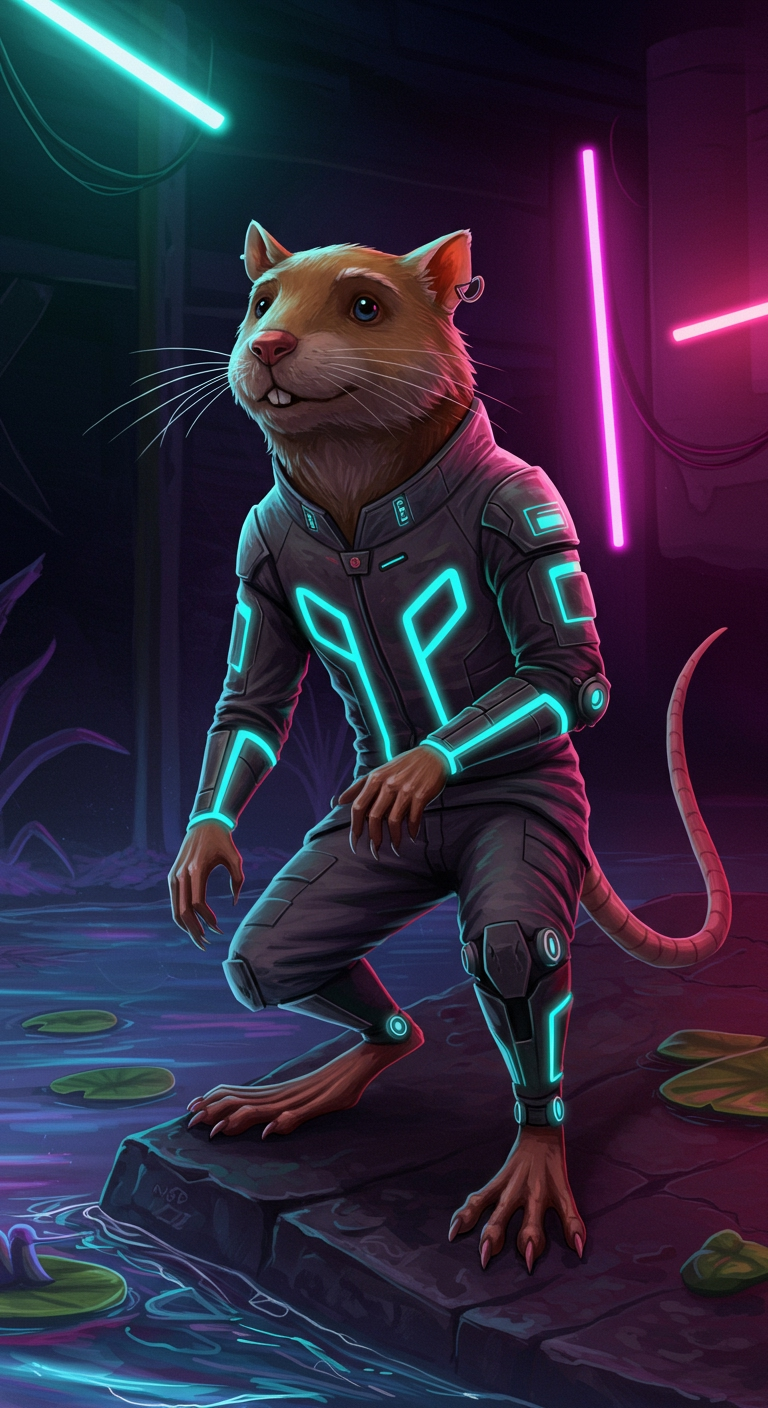

### badger

Visualize Mr. Badger in a futuristic utopia, illuminated by saturated and neon lights. He retains his solid and respectable nature, but his image is updated with subtle technological details. His simple, practical clothing now incorporates protective elements, such as reinforced plating and glowing power conduits. Imagine his strong, capable paws as augmented with cybernetic enhancements, which are activated with a soft neon glow. His face conveys wisdom, dependability, and no-nonsense demeanor. In the background, incorporate elements of advanced technology seamlessly integrated with nature, reflecting Badger's preference for underground living in a futuristic context. The overall scene should convey both strength and serenity, reflecting Badger's enduring character.

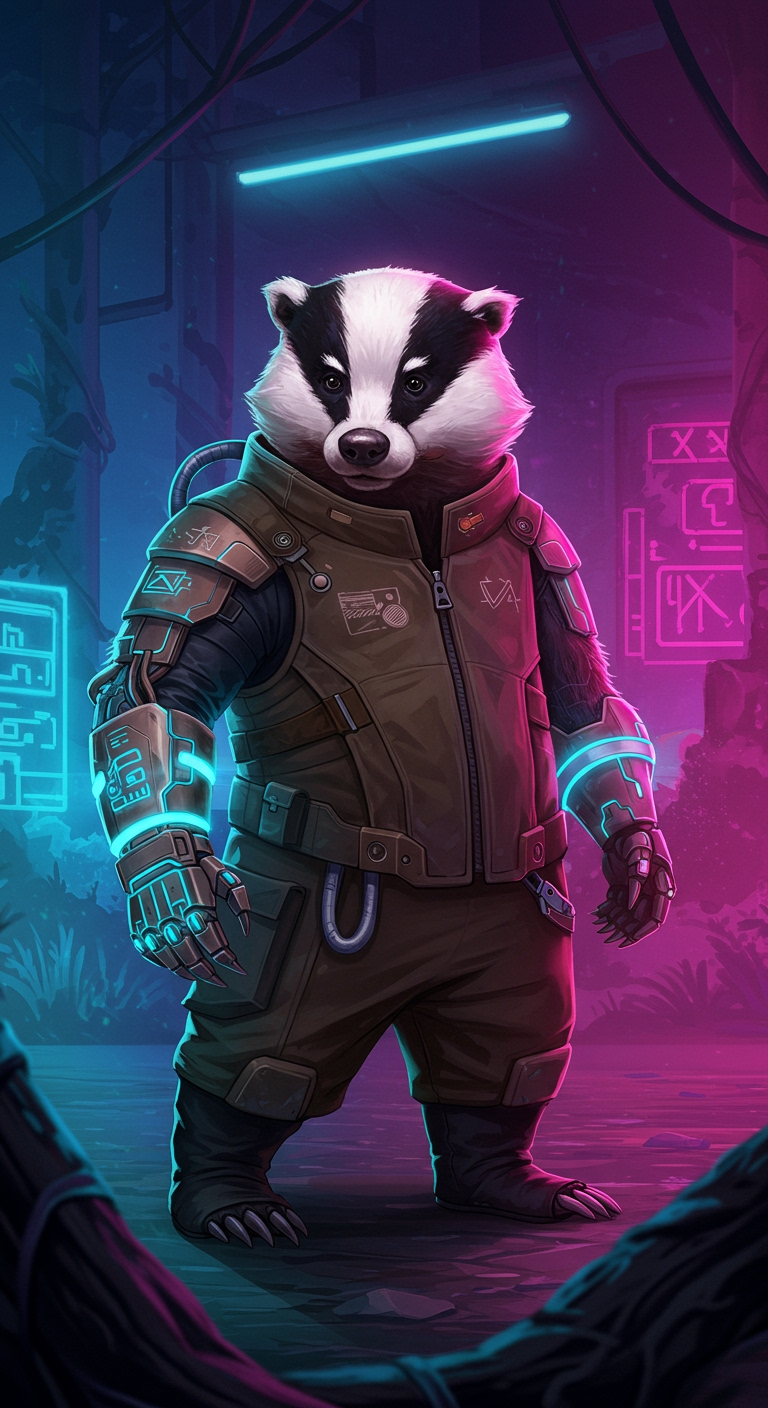

### toad

Illustrate a futuristic, science fiction version of Mr. Toad. He is to be the owner of toad-hall and is known for his handsome features. Envision Toad as a flamboyant figure garbed in a wildly extravagant outfit. His goggles and cap are sleek and futuristic, fitted with glowing neon lights. The overcoat now made of a shimmering, iridescent material. The color scheme should reflect Toad's love for bright, saturated colors. The setting should be an extravagant hover-car garage. This scene should scream wealth and lack of taste. 

In [ ]:
for character in characters:
  display(Markdown(f"### {character['name']}"))
  display(Markdown(character['prompt']))

  image_generated = client.models.generate_images(
      model=imagen_model_name,
      prompt=character['prompt'] + style + system_instructions,
      config=types.GenerateImagesConfig(
          number_of_images=1,
          output_mime_type="image/jpeg",
          safety_filter_level="BLOCK_LOW_AND_ABOVE",
          person_generation="ALLOW_ADULT",
          aspect_ratio="9:16"
      )
  )

  if image_generated.generated_images is not None:
    for generated_image in image_generated.generated_images:
      generated_image.image.show()

## 5/ Illustrate the chapters of the book

After the characters, it's now time to create illustrations for the content of the book. You are going to ask Gemini to generate prompts for each chapter and then ask Imagen to generate images based on those prompts.

In [ ]:
response = chat.send_message(["Now, for each chapter of the book, give me a prompt to illustrate what happens in it. Be very descriptive, especially of the characters. Remember to reuse the character prompts if they appear in the image"])

chapters = json.loads(response.text)[:max_chapter_images]

print(json.dumps(chapters, indent=4))

In [ ]:
for chapter in chapters:
  display(Markdown(f"### {chapter['name']}"))
  display(Markdown(chapter['prompt']))

  image_generated = client.models.generate_images(
      model=imagen_model_name,
      prompt=chapter['prompt'] + style + system_instructions,
      config=types.GenerateImagesConfig(
          number_of_images=1,
          output_mime_type="image/jpeg",
          safety_filter_level="BLOCK_LOW_AND_ABOVE",
          person_generation="ALLOW_ADULT",
          aspect_ratio="1:1"
      )
  )

  for generated_image in image_generated.generated_images:
    image = generated_image.image.show()

# Next Steps
### Useful documentation references:

To improve your prompting skills, check the [prompt guide](https://ai.google.dev/gemini-api/docs/imagen-prompt-guide) for great advices on creating your prompts.

### Related examples

If you're curious about cool things you can build with Imagen, check those great examples:
* [Zoom on earth](../examples/Zoom_on_earth.ipynb): Another take on mixing Gemini and Imagen, this time using [function calling](./Function_calling.ipynb) to communicate.
* [Generative designs](../examples/Generative_designs.ipynb): This time Gemini will ingest a bunch of images to serve as models to generate model designs.

### Continue your discovery of the Gemini API

Gemini is not only good at generating images, but also at understanding them. Check the [Spatial understanding](./Spatial_understanding.ipynb) guide for an introduction on those capabilities, and the [Video understanding](./Video_understanding.ipynb) one for video examples.

You should also have a look at the [Live API](../quickstarts/Get_started_LiveAPI.ipynb) to create live intereactions with the models.
